In [2]:
import gensim
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import konlpy
import fasttext
import re
import h5py

import sys, os 
from random import shuffle

import numpy as np

from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import MaxPooling1D, Embedding, Dense, Concatenate, Input, Reshape, Bidirectional, LSTM, Flatten, Dropout, Conv1D, Conv2D, MaxPooling2D, GRU, TimeDistributed
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.optimizers import Adam

# Preprocessing
## Read Data

In [3]:
category = range(0,8)
numTrain = range(0,160)
numTest = range(160,200)

def text_cleaner(text):
    cleantext = []
    publisher = "\((.*?)\)"
    braces = "\[(.*?)\]"
    braces2 = "\{(.*?)\}"
    braces3 = "\【(.*?)\】"
    writer = "특파원"
    writer2 = "기자"
    weird = "[=_\.,;:~…\"\"\'\'◇%\<\>/·○★☆]"
    tab = '\\t'
    newline = '\\n'
    for line in text:
        clean = re.sub(writer, '', line)
        clean = re.sub(writer2, '', clean)
        clean = re.sub(publisher,'', clean)
        clean = re.sub(braces,'', clean)
        clean = re.sub(braces2,'', clean)
        clean = re.sub(braces3,'', clean)
        clean = re.sub('[YTN,OSEN]','', clean)
        clean = re.sub(weird,'', clean)
        clean = re.sub(tab,'', clean)
        clean = re.sub(newline,'',clean)
        cleantext.append(clean)
    return cleantext

In [4]:
Xtrain = []
Ytrain = []
Xtest = []
Ytest = []
Xdata = []
Ydata = []

for n in range(0,200):
    for c in category:
        f = open('./newsData/{0}/{0}{1:03d}NewsData.txt'.format(c,n))
        Xdata.append(f.read())
        Ydata.append(c)
        
Ydata2 = list(Ydata)
Xdata2 = list(Xdata)

Xtrain = Xdata2[:1280]
Xtest = Xdata2[1280:]
Ytrain = Ydata2[:1280]
Ytest = Ydata2[1280:]

In [5]:
Xdata = text_cleaner(Xdata)
Xtrain = text_cleaner(Xtrain)
Xtest = text_cleaner(Xtest)

In [6]:
print(Xdata[:10])

['동남아 담당 北 최희철 부상 베이징 도착싱가포르행 주목최 부상 행선지방문 목적 질문에는 묵묵부답 김진방   북한이 북미 정상회담 무산 가능성까지 거론하며 강경한 태도를 보이는 가운데 동남아시아 외교를 담당하는 최희철 북한 외무성 부상이 19일 중국 베이징 서우두 공항에 모습을 드러냈다최 부상은 이날 오전 평양발 고려항공 J151편을 이용해 베이징 서우두 공항에 도착했다최 부상은 최종 목적지를 묻는 취재진의 질문에 아무런 답변을 하지 않고 북한 대사관 관계자들과 함께 공항을 빠져나갔다북미 정상회담을 20여 일 앞둔 상황에서 동남아 외교통인 최 부상이 정상회담 준비 등을 위해 회담 개최 예정지인 싱가포르를 방문할 가능성도 제기되고 있다최 부상은 지난 3월에도 아세안 의장국이기도 한 싱가포르를 방문해 양국관계와 올해 8월 열리는 아세안지역안보포럼 의제 등을 논의한 바 있다또 지난해 북핵 문제를 두고 북미 간 긴장관계가 형성됐을 때도 ARF에 참석해 아세안을 상대로 여론전을 펼쳤다 북한의 초청으로 비자이 쿠마르 싱 인도 외교부 국무장관이 방북했을 때도 최 부상은 싱 국무장관을 직접 영접하고 한반도 문제를 논의하기도 했다베이징 소식통은 최 부상이 대미 외교담당이 아니기 때문에 싱가포르로 갈 가능성이 큰 것은 아니다며 만약 싱가포르에 간다면 정상회담과 관련한 지원 작업 준비 등을 위한 것일 가능성이 크다고 말했다', ' 한달 새 두 번이나 LG 연구단지에 간 대통령국민이 선출한 일국의 대통령이란 자리는 시쳇말로 어마무시합니다 행정의 수반이자 외교적으로는 국가를 대표하는 얼굴이고 대부분 군 통수권까지 갖고 있습니다막강한 권한만큼 국민적 관심도 집중됩니다 사소한 말 한마디와 행동은 물론 옷차림과 먹는 음식 심지어 순식간에 스쳐 가는 표정에도 의미가 담깁니다 설사 그런 의도가 전혀 없더라도 누군가는 거기서 ‘맥락’을 뽑아내기 위해 열심이죠문재인 대통령도 마찬가지입니다 대통령을 보좌하는 청와대의 수많은 수석과 비서관 등이 국정철학을 극대화하고 효과적인 메시지를 전달하기 위해

### To build better word2vec model. use extra corpus

In [ ]:
dataForVec = list(Xdata)

corpus=[]
f = open("./corpusAll.txt", 'r')
lines = f.readlines()
for line in lines:
    corpus.append(line)
f.close()

corpus = text_cleaner(corpus)
print(len(corpus))

for i in range(len(corpus)):
    dataForVec.append(corpus[i])
    
dataForVec = dataForVec[:500000]

In [ ]:
print(len(dataForVec))
print(dataForVec[:10])

In [ ]:
del corpus

## Tokenize

### Use Nouns and Verbs Only

In [7]:
def morphs_process(lines, tagger):
    sentences = []
    for line in lines:
        sentence = []
        pos = tagger.pos(line)
        for pair in pos:
            if (pair[1] in ['NNG','NNP','NNB'
                            ,'NNBC','NR','NP'
                            ,'VV','VA','VX'
                            ,'VCP','VCN']) :
                morpheme = pair[0]
                sentence.append(morpheme)
            else:
                pass
        sentences.append(sentence)
    return sentences

In [8]:
def tokenExport(tokens, filename):
    f = open(filename, 'w')
    f.write('\n')
    for line in tokens:
        f = open(filename, 'a')
        f.writelines(' '.join(line))
        f.write('\n')

In [9]:
mec = konlpy.tag.Mecab()
tw = konlpy.tag.Twitter()

In [10]:
Xtrain = morphs_process(Xtrain, mec)
Xtest = morphs_process(Xtest, mec) 
Xdata = morphs_process(Xdata, mec)
dataForVec = morphs_process(dataForVec, mec)

In [11]:
print(Xtrain[:10])
print(len(Xtrain))

[['동남아', '담당', '北', '최희철', '부상', '베이징', '도착', '싱가포르', '주목', '부상', '행선', '지방문', '목적', '질문', '묵묵부답', '김진방', '북한', '북미', '정상', '회담', '무산', '가능', '거론', '태도', '보이', '가운데', '동남아시아', '외교', '담당', '최희철', '북한', '외무성', '부상', '일', '중국', '베이징', '서우', '공항', '모습', '부상', '이날', '오전', '평', '양발', '고려항공', '편', '이용', '베이징', '서우', '공항', '도착', '부상', '최종', '목적지', '묻', '취재진', '질문', '답변', '하', '않', '북한', '대사관', '관계자', '공항', '북미', '정상', '회담', '일', '상황', '동남아', '외교통', '부상', '정상', '회담', '준비', '등', '회담', '개최', '예정지', '싱가포르', '방문', '가능', '제기', '있', '부상', '월', '아세안', '의장국', '이', '싱가포르', '방문', '양국', '관계', '올해', '월', '열리', '아세안', '지역', '안보', '포럼', '의제', '등', '논의', '바', '있', '지난해', '북', '핵', '문제', '두', '북미', '간', '긴장', '관계', '형성', '때', '참석', '아세안', '상대', '여론전', '북한', '초청', '비자이', '쿠마르', '싱', '인도', '외교부', '국무', '장관', '방북', '때', '부상', '싱', '국무', '장관', '영접', '한반도', '문제', '논의', '베이징', '소식통', '부상', '대미', '외교', '담당', '아니', '때문', '싱가포르', '가능', '것', '아니', '만약', '싱가포르', '정상', '회담', '관련', '지원', '작업', '준비', '등', '것', '가능', '크', '말

In [ ]:
tokenExport(dataForVec, 'tokens.txt')

In [ ]:
del dataForVec

## Word Vector Model
### FT model 

In [ ]:
def ftmodelmake(data, model, lr = 0.1, dim = 300, ws = 5, min_count = 10):
    model = fasttext.skipgram(data, model, lr = lr, dim = dim, ws = ws, min_count = min_count)
    print(len(model.words))
    return model

In [ ]:
ftmodel = ftmodelmake('tokens.txt', 'ftmodel')

In [12]:
ftModel = KeyedVectors.load_word2vec_format('ftmodel.vec')
ftVocab= list(ftModel.wv.vocab)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [13]:
def similarTest(model, word):
    ftsimilars = model.most_similar(positive=[word], topn=10)
    for word, value in ftsimilars:
        print(word, value)
    print('\n')

In [14]:
similarTest(ftModel, '트럼프')

도널드 0.5814574956893921
오바마 0.47336798906326294
비핵화 0.43146321177482605
백악관 0.4286015033721924
줄리아니 0.42347168922424316
허커비 0.41646575927734375
대통령 0.4144159257411957
버락 0.4141687750816345
공화 0.4085821807384491
회담 0.3984195291996002




/usr/local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Embedding Index

In [15]:
def ebdIdx(model, vocab_list):
    embd_idx = {}

    for w in vocab_list:
        embd_idx[w] = model.__getitem__(w)

    print(len(embd_idx))
    return embd_idx

In [16]:
embedding_idx = ebdIdx(ftModel, ftVocab)

32707


## Train/Test Data Embedding

In [17]:
def getSequence(text, MAX_FEATURES, word_index):
    seq = []
    for line in text:
        lineseq = []
        for i in range(len(line)):
            if (word_index[line[i]] < MAX_FEATURES):
                lineseq.append(word_index[line[i]])
            else:
                pass
        seq.append(lineseq)
    seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    seq = np.array(seq)
    return seq

In [18]:
MAX_FEATURES = len(embedding_idx)
MAX_SEQUENCE_LENGTH = 525
EMBEDDING_DIM = 300
print(MAX_FEATURES)

32707


In [19]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(Xdata)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(Xdata)
seqlen = np.array([len(sequence) for sequence in sequences])
np.histogram(seqlen, bins=50)

(array([  7,  21,  36,  63,  79, 102,  70,  74,  96,  99,  93,  88,  74,
         73,  80,  65,  78,  40,  52,  47,  30,  22,  41,  20,  32,  29,
         22,   9,   7,   9,   7,   7,   5,   6,   1,   2,   3,   2,   2,
          3,   0,   2,   1,   0,   0,   0,   0,   0,   0,   1]),
 array([ 53.  ,  66.36,  79.72,  93.08, 106.44, 119.8 , 133.16, 146.52,
        159.88, 173.24, 186.6 , 199.96, 213.32, 226.68, 240.04, 253.4 ,
        266.76, 280.12, 293.48, 306.84, 320.2 , 333.56, 346.92, 360.28,
        373.64, 387.  , 400.36, 413.72, 427.08, 440.44, 453.8 , 467.16,
        480.52, 493.88, 507.24, 520.6 , 533.96, 547.32, 560.68, 574.04,
        587.4 , 600.76, 614.12, 627.48, 640.84, 654.2 , 667.56, 680.92,
        694.28, 707.64, 721.  ]))

In [20]:
x_train = getSequence(Xtrain, MAX_FEATURES, word_index)
x_test = getSequence(Xtest, MAX_FEATURES, word_index)
y_train = to_categorical(np.asarray(Ytrain))
y_test = to_categorical(np.asarray(Ytest))

In [21]:
print('Shape of x_train tensor:', x_train.shape)
print('Shape of y_train tensor:', y_train.shape)
print('Shape of x_test tensor:', x_test.shape)
print('Shape of y_test tensor:', y_test.shape)
print(np.amax(x_train))
print(np.amax(y_train))
print(x_train[0])
print(y_train[0])

Shape of x_train tensor: (1280, 525)
Shape of y_train tensor: (1280, 8)
Shape of x_test tensor: (320, 525)
Shape of y_test tensor: (320, 8)
20861
1.0
[ 4445   878   905 11254   700   957  1129   982   561   700 14625 14626
  1189   413  5495  7241    23   150    30    25  1705    52  1407   931
   219   189 11255   562   878 11254    23  2648   700     4    35   957
  9402   790   117   700    39   158  2878 14627  7242   729   169   957
  9402   790  1129   700   528  6544   893  1878   413  1430     9     8
    23  1431    65   790   150    30    25     4    72  4445 14628   700
    30    25   261     5    25   252 11256   982   464    52   322     1
   700    13  5496 11257     2   982   464  1602   140   133    13   407
  5496    87   996  3002  3407     5   295   178     1    63   311   156
    58   286   150    85  1504   140  1265    31   421  5496   271 14629
    23  1432 14630 14631  3945   808  2408   587   276  1639    31   700
  3945   587   276  8180   364    58   295   95

In [22]:
print('Preparing embedding matrix...')

num_words = min(MAX_FEATURES, len(ftVocab) + 1) #unknown word 때문에 +1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_FEATURES:
        continue
    embedding_vector = embedding_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix...


In [23]:
print(embedding_matrix.shape)

(32707, 300)


## Model Build, Train & Evaluate
### Common

In [24]:
# path where all models are saved
BASE_PATH = './model_180715/'
if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

In [25]:
def create_checkpoint(model_name):
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_loss-{val_loss:.4f}.hdf5'),
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True)

def create_checkpoint2(model_name):
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_acc-{val_acc:.4f}.hdf5'),
                           monitor='val_acc',
                           verbose=1,
                           save_best_only=True)

In [26]:
batch_size = 32
max_epochs = 100

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10)

### RNN - LSTM

In [27]:
def LSTMmodel(hiddenlayer = 64, drop = 0.5):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    dropout = Dropout(drop)(embedded_sequences)

    lstm_1 = Bidirectional(LSTM(hiddenlayer, return_sequences=True))(dropout)
    lstm_2 = Bidirectional(LSTM(hiddenlayer, return_sequences=True))(lstm_1)
    lstm_3 = Bidirectional(LSTM(hiddenlayer, return_sequences=True))(lstm_2)
    lstm_4 = Bidirectional(LSTM(hiddenlayer))(lstm_3)
    preds = Dense(8, activation='softmax')(lstm_4)

    model = Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()
    checkloss = create_checkpoint('LSTM') 
    checkacc = create_checkpoint2('LSTM')

    print('Training...')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=max_epochs,
              validation_split=0.15,
              shuffle=True,
              callbacks=[checkloss, checkacc, early_stopping])
    return model, history

### RNN - GRU

In [28]:
def GRUmodel(hiddenlayer = 64, drop = 0.5):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    dropout = Dropout(drop)(embedded_sequences)

    gru_1 = Bidirectional(GRU(hiddenlayer, return_sequences=True))(dropout)
    gru_2 = Bidirectional(GRU(hiddenlayer, return_sequences=True))(gru_1)
    gru_3 = Bidirectional(GRU(hiddenlayer, return_sequences=True))(gru_2)
    gru_4 = Bidirectional(GRU(hiddenlayer))(gru_3)
    preds = Dense(8, activation='softmax')(gru_4)

    model = Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()

    checkloss = create_checkpoint('GRU') 
    checkacc = create_checkpoint2('GRU')
    
    print('Training...')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=max_epochs,
              validation_split = 0.15,
              shuffle=True,
              callbacks=[checkloss, checkacc, early_stopping])
    return model, history

### CNN

In [29]:
def CNNModel(num_filters = 128, drop =0.7):
    filter_sizes = [3,4,5,6]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedded_sequences)

    conv_0 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[0], EMBEDDING_DIM), 
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[1], EMBEDDING_DIM), 
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[2], EMBEDDING_DIM), 
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape)
    conv_3 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[3], EMBEDDING_DIM), 
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape)


    maxpool_0 = MaxPooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), 
                             strides=(1,1), 
                             padding='valid')(conv_0)
    maxpool_1 = MaxPooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), 
                             strides=(1,1), 
                             padding='valid')(conv_1)
    maxpool_2 = MaxPooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), 
                             strides=(1,1), 
                             padding='valid')(conv_2)
    maxpool_3 = MaxPooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[3] + 1, 1), 
                             strides=(1,1), 
                             padding='valid')(conv_3)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    preds = Dense(8, activation='softmax')(dropout)

    model = Model(sequence_input, preds)
    model.summary()

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkloss = create_checkpoint('CNN') 
    checkacc = create_checkpoint2('CNN')
    
    print('Training...')
    history = model.fit(x_train, y_train, 
              batch_size=batch_size, 
              epochs=max_epochs, 
              verbose=1, 
              shuffle=True,
              callbacks=[checkloss, checkacc, early_stopping], 
              validation_split=0.15) 
    return model, history

### CNN+LSTM

In [30]:
def CNNLSTMModel(filter_sizes = 128, drop = 0.5):    
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    dropout = Dropout(drop)(embedded_sequences)
    
    conv_0 = Conv1D(filter_sizes, 5, activation='relu')(dropout)
    maxpool_0 = MaxPooling1D(pool_size=4)(conv_0)
    conv_1 = Conv1D(filter_sizes, 5, activation='relu')(maxpool_0)
    maxpool_1 = MaxPooling1D(pool_size=4)(conv_1)
    conv_2 = Conv1D(filter_sizes, 5, activation='relu')(maxpool_1)
    maxpool_2 = MaxPooling1D(pool_size=4)(conv_2)
    lstm = LSTM(128)(maxpool_2)
    preds = Dense(8, activation='softmax')(lstm)
    
    model = Model(sequence_input, preds)
    model.summary()

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkloss = create_checkpoint('CNN+LSTM') 
    checkacc = create_checkpoint2('CNN+LSTM')
    
    print('Training...')
    history = model.fit(x_train, y_train, 
              batch_size=batch_size, 
              epochs=max_epochs, 
              verbose=1, 
              callbacks=[early_stopping, checkloss, checkacc], 
              validation_split = 0.15) 
    return model, history

### CNN+GRU

In [31]:
def CNNGRUModel(filter_sizes = 128, drop = 0.5):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    dropout = Dropout(drop)(embedded_sequences)
    
    conv_0 = Conv1D(filter_sizes, 5, activation='relu')(dropout)
    maxpool_0 = MaxPooling1D(pool_size=4)(conv_0)
    conv_1 = Conv1D(filter_sizes, 5, activation='relu')(maxpool_0)
    maxpool_1 = MaxPooling1D(pool_size=4)(conv_1)
    conv_2 = Conv1D(filter_sizes, 5, activation='relu')(maxpool_1)
    maxpool_2 = MaxPooling1D(pool_size=4)(conv_2)
    gru = GRU(128)(maxpool_2)
    preds = Dense(8, activation='softmax')(gru)
    
    model = Model(sequence_input, preds)
    model.summary()

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkloss = create_checkpoint('CNN+GRU') 
    checkacc = create_checkpoint2('CNN+GRU')
    
    print('Training...')
    history = model.fit(x_train, y_train, 
              batch_size=batch_size, 
              epochs=max_epochs, 
              verbose=1, 
              callbacks=[early_stopping, checkloss, checkacc], 
              validation_split = 0.15) 
    return model, history

In [ ]:
lstm = LSTMmodel()

In [ ]:
gru = GRUmodel()

In [32]:
cnn = CNNModel()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 525)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 525, 300)     9812100     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 525, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 523, 1, 128)  115328      reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

1088/1088 [==============================] - 16s 15ms/step - loss: 0.0076 - acc: 0.9991 - val_loss: 0.4424 - val_acc: 0.8646

Epoch 00045: val_loss did not improve from 0.43997

Epoch 00045: val_acc improved from 0.85938 to 0.86458, saving model to ./model_180717/CNN/val_acc-0.8646.hdf5
Epoch 46/100
1088/1088 [==============================] - 16s 15ms/step - loss: 0.0087 - acc: 0.9991 - val_loss: 0.4427 - val_acc: 0.8594

Epoch 00046: val_loss did not improve from 0.43997

Epoch 00046: val_acc did not improve from 0.86458
Epoch 47/100
1088/1088 [==============================] - 16s 15ms/step - loss: 0.0082 - acc: 0.9982 - val_loss: 0.4466 - val_acc: 0.8438

Epoch 00047: val_loss did not improve from 0.43997

Epoch 00047: val_acc did not improve from 0.86458
Epoch 48/100
1088/1088 [==============================] - 16s 15ms/step - loss: 0.0161 - acc: 0.9982 - val_loss: 0.4432 - val_acc: 0.8490

Epoch 00048: val_loss did not improve from 0.43997

Epoch 00048: val_acc did not improve fr

In [ ]:
cnnlstm = CNNLSTMModel()

In [ ]:
cnngru = CNNGRUModel()

### Plot and Evaluation

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_train(history):
    fig, loss_ax = plt.subplots(figsize=(6,6))
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_ylim([0.0, 3.0])

    acc_ax.plot(history.history['acc'], 'b', label='train acc')
    acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
    acc_ax.set_ylim([0.0, 1.1])

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()
    
def test_summary(model, weight_path):
    plot_train(model[1])
    model[0].load_weights(weight_path)
    loss, acc = model[0].evaluate(x_test, y_test, batch_size=batch_size)
    print('----- Evaluation loss and metrics -----')
    print('Test loss:', loss)
    print('Test accuracy:', acc)
    
def saveModel(model, name):
    model_json = model[0].to_json()
    with open(name, "w") as json_file:
        json_file.write(model_json)

def loadModel(modelfile, weightfile):
    json_file = open(modelfile, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(weightfile)
    loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return loaded_model

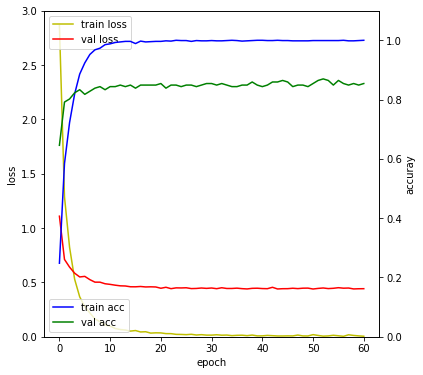

320/320 [==============================] - 2s 5ms/step
----- Evaluation loss and metrics -----
Test loss: 0.5007837802171707
Test accuracy: 0.878125


In [44]:
test_summary(cnn,'./model_180715/CNN/val_loss-0.4396.hdf5')

In [38]:
#saveModel(gru, 'gru-0.828.json')
#saveModel(lstm, 'lstm-825.json')
saveModel(cnn, 'cnn-0.878.json')
#saveModel(cnngru, 'cnngru-0.856.json')
#saveModel(cnnlstm, 'cnnlstm-0.853.json')

In [40]:
cnnbes = loadModel('./cnn-0.878.json','./model_180715/CNN/val_loss-0.4396.hdf5')

In [41]:
loss, acc = cnnbes.evaluate(x_test, y_test, batch_size=batch_size)
print('----- Evaluation loss and metrics -----')
print('Test loss:', loss)
print('Test accuracy:', acc)

320/320 [==============================] - 2s 6ms/step
----- Evaluation loss and metrics -----
Test loss: 0.5007837802171707
Test accuracy: 0.878125
